In [85]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar xvzf /content/maps.tar.gz
!pip install pytorch-lightning


'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
tar: Error opening archive: Failed to open '/content/maps.tar.gz'


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer


# Generating Images

The main focus of this lab will be generative models. The goal of a generative model is to learn how to generate an image from a low-dimensional input code called a latent code. There exists many approches for image generation such as auto-encoders, Generative Adversarial Networks (GAN) or even diffusion models.

In recent years, generative models have achieve ground-breaking performances in multiple applications in industry (NFT Creation, Virtual Try Outs, Deep Fake Generation..). You might have heard of such success in caption to image generation with diffusion models such as [MidJourney](https://www.midjourney.com/) or [Stable Diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion).

Goal of this lab :
* Hands on Generative Models
* Solidify your knowledge in Deep Learning
* Use someone else's code
* Reuse Pytorch Lightning
* Have an Insight of industrial application of AI

## Back to the Basics : AutoEncoders

First, we are going to start from the simplest approach to image generation: auto-encoders. As you might remember, we used an AutoEncoder in your 2nd year labs to recreate some input images for compression purposes. In this part, we will reconstruct data from the MNIST Dataset.


### Lightning DataModule

We will reuse the MNIST datamodule used in the first lab. So just run the following cell.

In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size = batch_size

    def prepare_data(self):
        # This method is used to download beforehand the dataset if needed.
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        # First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            mnist_train_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            self.train_size = int(0.8 * len(mnist_train_dataset))
            self.valid_size = len(mnist_train_dataset) - self.train_size
            self.mnist_train, self.mnist_valid =  torch.utils.data.random_split(mnist_train_dataset, [self.train_size, self.valid_size])
        # Second stage is 'test'
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_valid, self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.mnist_test,self.batch_size, shuffle=False)

### Lightning Module

In [3]:

class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvDown, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.out_channels,
                                            kernel_size = 3,
                                            stride = 1,
                                            padding = 0,
                                            dilation = 1),
                                  nn.BatchNorm2d(self.out_channels),
                                  nn.Dropout2d(0.5),
                                  nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class ConvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvUp, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.ConvTranspose2d(in_channels = self.in_channels,
                                      out_channels = self.out_channels,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 0,
                                      dilation = 1),
                    nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    channels = [in_channels]+ [2**i for i in range(3,10)]
    self.encoder = nn.ModuleList([ConvDown(channels[i], channels[i+1]) for i in range(number_of_stack)])

  def forward(self, x):
    for i, layer in enumerate(self.encoder):
      x = layer(x)
    return x

class Decoder(nn.Module):
  def __init__(self, out_channels,number_of_stack ):
    super(Decoder, self).__init__()
    channels = [out_channels]+ [2**i for i in range(3,10)]
    self.decoder = nn.ModuleList([ConvUp(channels[i+1], channels[i]) for i in range(number_of_stack)])[::-1]

  def forward(self, x):
    for i, layer in enumerate(self.decoder):
      x = layer(x)
    return x

############################################## TODO ##############################################
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super().__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    self.encoder = Encoder(self.in_channels, number_of_stack)
    self.decoder = Decoder(self.in_channels, number_of_stack)

  def forward(self, x):
    # TODO : Define your forward
    latent_representation = self.encoder(x)
    reconstructed_image = self.decoder(latent_representation)
    return reconstructed_image

# TODO : Create a model composed of 3 stacks

In [4]:
model = AutoEncoder(1,3)
print(model)

AutoEncoder(
  (encoder): Encoder(
    (encoder): ModuleList(
      (0): ConvDown(
        (model): Sequential(
          (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ConvDown(
        (model): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ConvDown(
        (model): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): LeakyReLU(negative_slope=0.2)




*   Create your Lightning Module



In [5]:
class AutoEncoderPL(pl.LightningModule):
    def __init__(self, in_channels, number_of_stack):
        super().__init__()
        self.save_hyperparameters()
        # TODO : Define your model here.
        self.model = AutoEncoder(in_channels=in_channels,number_of_stack=number_of_stack)

    def forward(self,x):
        # TODO : Send the input through your model
        x = self.model.forward(x)
        return x

    def configure_optimizers(self):
        # Choose your optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        # Define your Training Step
        # This method is pretty much similar to what your did in the first lab to train your model.
        x,y = train_batch
        x_reconstructed = self.forward(x)
        loss = F.mse_loss(x_reconstructed,x)
        # Don't remove the next line, you will understand why later
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        # Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        x,y = val_batch
        x_reconstructed = self.forward(x)
        loss = F.mse_loss(x_reconstructed,x)
        self.log('val_loss', loss)

    def test_step(self, test_batch, batch_idx):
        # Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x,y = test_batch
        x_reconstructed = self.forward(x)
        loss = F.mse_loss(x_reconstructed,x)
        # Don't remove the next line, you will understand why later
        self.log('test_loss', loss)
        return x,x_reconstructed
        

    # TODO : Do we have to add some functions (test_epoch_start, test_epoch_end..) to compute a reconstruction metric ?
    

#### Training

##### Setting TensorBoard up

**I use the tensorboard as a separate instance**

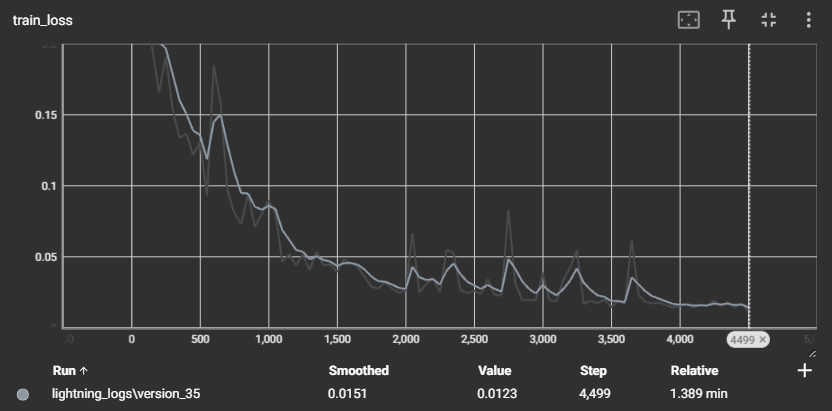
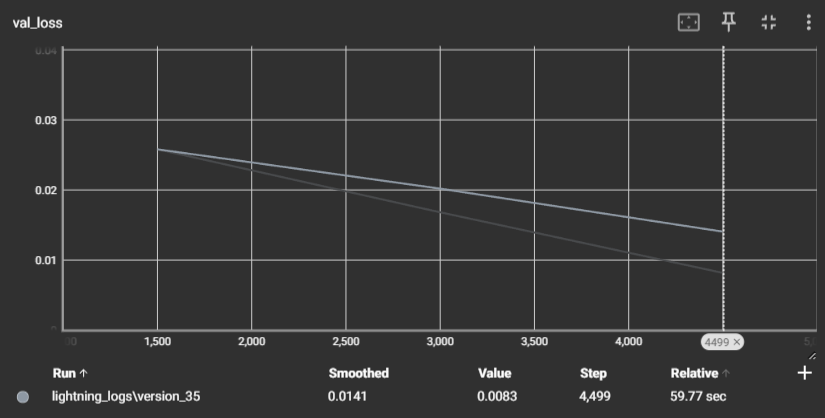

##### Launch the Training

In [188]:
# TODO :
model = AutoEncoderPL(1,3)
dm = MNISTDataModule(32)
trainer = pl.Trainer(max_epochs=3)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 11.9 K | train
----------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 1500/1500 [00:30<00:00, 49.23it/s, v_num=35]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1500/1500 [00:30<00:00, 49.19it/s, v_num=35]


#### Testing

Test some images from the testing dataset to verify that your model works.

In [189]:
# TODO : Load your test dataloader from the datamodule
dm.setup('test')
dm_test = dm.test_dataloader()
# TODO : Compute your average reconstruction on the test set.
trainer.test(model,dm_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:03<00:00, 82.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.00817732885479927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.00817732885479927}]

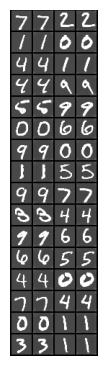

In [190]:
# TODO : Plot some reconstructed images. Are they correct ?
input_imgs = next(iter(dm.test_dataloader()))[0]
model.eval()
with torch.no_grad():
        reconst_imgs = model(input_imgs)
imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1, 1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7, 4.5))
plt.imshow(grid)
plt.axis("off")
plt.show()

### Going Further on AutoEncoders (Optional)

If you have some time, create other AutoEncoder with differnet latent sizes and train it.
* **What is the impact of the latent space toward the images reconstructions ?**

In [9]:
model = AutoEncoderPL(1,3)
dm = MNISTDataModule(32)
trainer = pl.Trainer(max_epochs=6)
trainer.fit(model, dm)
trainer.test(model,dm_test)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 11.9 K | train
----------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1500/1500 [00:29<00:00, 50.92it/s, v_num=38]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1500/1500 [00:29<00:00, 50.89it/s, v_num=38]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\JERM\anaconda3\envs\torch3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:03<00:00, 90.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.005088334437459707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.005088334437459707}]

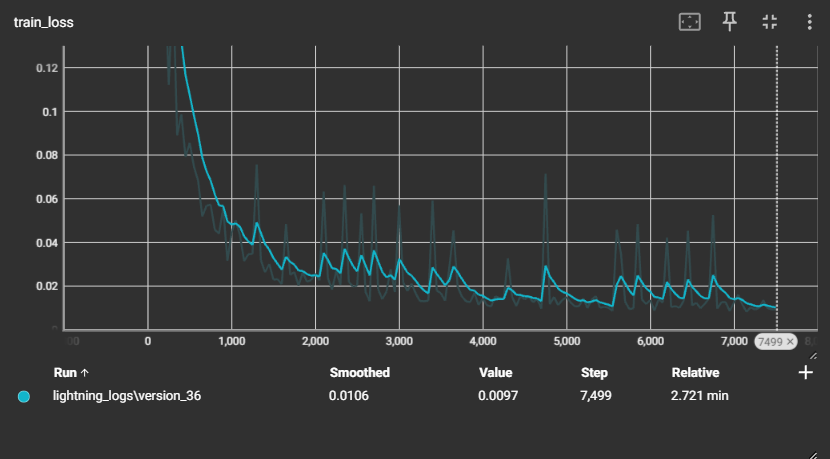
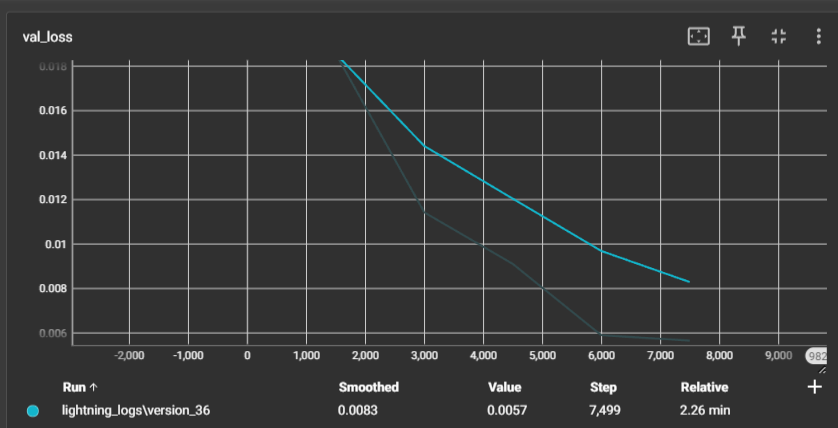

AutoEncoderPL(
  (model): AutoEncoder(
    (encoder): Encoder(
      (encoder): ModuleList(
        (0): ConvDown(
          (model): Sequential(
            (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Dropout2d(p=0.5, inplace=False)
            (3): LeakyReLU(negative_slope=0.2)
          )
        )
        (1): ConvDown(
          (model): Sequential(
            (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Dropout2d(p=0.5, inplace=False)
            (3): LeakyReLU(negative_slope=0.2)
          )
        )
        (2): ConvDown(
          (model): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Dropo

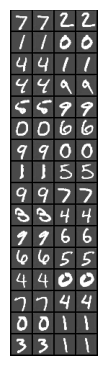

In [ ]:
dm.setup('test')
dm_test = dm.test_dataloader()
# TODO : Compute your average reconstruction on the test set.
input_imgs = next(iter(dm.test_dataloader()))[0]

model.eval()
with torch.no_grad():
        reconst_imgs = model(input_imgs)
imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1, 1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7, 4.5))
plt.imshow(grid)
plt.axis("off")
plt.show()

## Industrial Application of GAN : Creating Google Maps Calque from Google Map Satellite view

Working on basic datasets such as MNIST is insightful but far from the reality you will face as an engineer. Let's turn to industrial datasets: given an image of a Google Map Satellite view, we want the model to predict a Calque view from it. This task is called image translation task.

For example, using the image on the left, we want the model to predict the image on the right.
<img src="https://eu42.github.io/images/gcgan/aerial_image_map_example.png" height = 200>


### Lightning DataModule



#### Dataset

First, we need to write the Dataset. As usual, a custom Dataset class must implement three functions:
* __init__
* __len__
* __getitem__

Each image's shape is 1200x600x3. The satellite and the calque has the same size and are exactly half of the image

As the dataset doesn't have a proper test dataset, we will use the validation dataset as the test set. We will further create a validation dataset by taking a portion of the train dataset

In [118]:
class GoogleDataset(Dataset):

  def __init__(self, path, transform = None):
    self.path = path
    self.images = [path + i for i in os.listdir(path)]
    self.transform = transform

  def __getitem__(self,idx):
    image = self.images[idx]
    full_image = cv2.imread(image)
    h,w,c = full_image.shape
    # TODO : Retrieve the correct parts of the image.
    satellite = full_image[0:h/2,0:w/2,:]
    calque = full_image[0:h/2,0:w/2,:]
    if self.transform :
      satellite = self.transform(satellite)
      calque = self.transform(calque)
    return {'satellite':satellite,
            'calque':calque}

  def __len__(self):
    return len(self.images)


In [180]:
train = GoogleDataset('maps/maps/train')
val = GoogleDataset('maps/maps/val')


#### Lightning DataModule

Now, let's prepare our DataModule.

In [181]:
class GoogleMapDataModule(pl.LightningDataModule):

    def __init__(self, batch_size):
        super().__init__()
        # TODO : In your Transformation, transform to Tensor and resize images to 128x128
        self.transform =  transforms.Compose([[transforms.ToTensor(), transforms.Resize([128,128])]])
        self.batch_size = batch_size

        # we are hardcoding the path are they won't change
        self.train_path = 'maps/maps/train/'
        self.test_path = 'maps/maps/val/'

    def prepare_data(self):
        # TODO : load the train and test dataset 
        train = GoogleDataset('maps/maps/train',self.transform)
        val = GoogleDataset('maps/maps/val',self.transform)



    def setup(self, stage):

        #First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            google_train = GoogleDataset(self.train_path, self.transform)
            train_size = int(0.7 * len(google_train ))
            test_size = len(google_train ) - train_size
            self.google_train, self.google_valid =  torch.utils.data.random_split(google_train , [train_size, test_size])
        #Second stage is 'test'
        if stage == "test" or stage is None:
            self.google_test = GoogleDataset(self.test_path, self.transform)

    def train_dataloader(self):
        # TODO : Now create your Training DataLoader
        return DataLoader(self.google_train,batch_size=self.batch_size)

    def val_dataloader(self):
        # TODO : Now create your Validation DataLoader
        return DataLoader(self.google_valid,batch_size=self.batch_size)

    def test_dataloader(self):
        # TODO : Now create your Testing DataLoader
        return DataLoader(self.google_test,batch_size=self.batch_size)

### Lightning Module

* **Can we use an AutoEncoder to perform this task ?**


**Yes, by training the decoder on the right images, the model will generate similar images**

Regardless of your answer in the previous question, we choose to turn to a more complex model: Generative Adversarial Networks (**GAN**).

GAN is a type of generative model composed of two different sub-networks: the generator and the discriminator. It has been and is still in some applications one of the most efficient model for image generation tasks. We won't be working directly on a GAN but rather on its conditioned version (**cGAN**), which is very close in its learning process.


#### cGAN : Adding a Condition to the GAN
<img src='https://www.researchgate.net/profile/Gerasimos-Spanakis/publication/330474693/figure/fig1/AS:956606955139072@1605084279074/GAN-conditional-GAN-CGAN-and-auxiliary-classifier-GAN-ACGAN-architectures-where-x_Q320.jpg'>

 In contrast with a normal GAN, cGAN has a condition that will help us **control** how the GAN should generate images. The generator will be guided by the Condition during generation. For example, if you want to generate digits from the MNIST Dataset, you can add a condition to force the GAN to create a specific Digit. In the case of MNIST, the condition would be the class label.

Further details are in the following paper : https://arxiv.org/pdf/1411.1784.pdf


##### <u>The Generator</u> : Generating Images

In general, the Generator is here to generate Data from Noise. For example if we train a GAN on MNIST dataset, the generator will create digits using the noise we give it as input. In this lab, we are dealing with cGANs, so we need a Condition to condition our GAN.
* **What could be the condition in this task ?**
**Here the condition is the calque**
To answer that :
* **What are we trying to do ?**
We generate fake images and using a discriminator to differenciate the fake images from the real images, train the generator to create images closer to real images.
* **What should the Generator do ? Should it recreate something specific ?**
The generator generates random images that get gradually closer to the real images as its weights are adjusted to fit the real images.


Let's use an AutoEncoder to perform the image translation.
* **Using previous classes, initialize your Generator using a 3 stack AutoEncoder.**

In [178]:
class AutoEncoder2(nn.Module):
  def __init__(self, in_channels, number_of_stack,out_channels):
    super().__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    self.out_channels=out_channels
    self.encoder = Encoder(self.in_channels, self.number_of_stack)
    self.decoder = Decoder(self.out_channels, self.number_of_stack)

  def forward(self, x):
    # TODO : Define your forward
    latent_representation = self.encoder(x)
    reconstructed_image = self.decoder(latent_representation)
    return reconstructed_image
  
class Generator(nn.Module):
    # TODO : Create your Generator using the previous AutoEncoder Class
    def __init__(self,in_channels,latent_size,out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.latent_size = latent_size
        self.out_channels=out_channels
        self.model = AutoEncoder2(self.in_channels, self.latent_size,self.out_channels)

    def forward(self,x):
        out=self.model(x)
        return out


##### <u>The Discriminator</u> : Forcing the Generator to predict better

The generator is able to create Images from Inputs, but we want the best quality possible. We need a model that would indicate to the Generator whether the generated images are correct or not : the Discriminator.

The Discriminator is here to force the Generator to create better and better images. While the Generator creates bad quality generated image, the Discriminator will give a feedback.

<img src="https://i.imgflip.com/6y0kqe.jpg">

* **What could be the worst case scenario with the Generator and the Discriminator ?**
- The discriminator gives a wrong feedback and decreases the generator's performance

* We provide you the code of a Discriminator that "works well".

In [168]:

class DiscriConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                                  out_channels = out_channels,
                                  kernel_size = kernel_size,
                                  stride = 2,
                                  padding = 1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.LeakyReLU(0.2, inplace=True))

  def forward(self,x):
      return self.model(x)

class Discriminator(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(DiscriConv(in_channels, 32,3),
                              DiscriConv(32, 64,4),
                              DiscriConv(64, 128,4),
                              # 128x4x4
                              nn.Conv2d(in_channels = 128,
                                        out_channels = out_channels,
                                        kernel_size = 3,
                                        bias=False))

  def forward(self, input):
    return self.main(input)

##### The Loss : Adversarial Battle

<!-- <img src="https://miro.medium.com/max/1400/1*d96q6bCKbmZT9Ls7f3X6xg.jpeg"> -->

$$\mathcal{L}_{cGAN}(G,D)=\mathbb{E}_{x,y}[\log D(x,y)]+\mathbb{E}_{x,z}[\log(1-D(x,G(x, z))]$$

$$\mathcal{L}_{L1}(G)=\mathbb{E}_{x,y,z}[\|y-G(x,z)\|_1] \qquad\text{ or }\qquad \mathcal{L}_{L2}(G)=\mathbb{E}_{x,y,z}(y-G(x,z))^2$$

This formula is the basic loss of the cGAN model. There are two terms, each optimizing specific part of the model.
Beautiful formulas, isn't it ? Let's properly understand them.
* What is x, y, z in our Case ?

**Here x is the satellite image, y is the calque image and z is the input image**

If we look at the formulas, there are two losses :
* What kind of losses are they ? Cross Entropies, Distance Losses ?
**both are distance losses**

* Which term is the Discriminator loss ? Generator loss ?
**The first loss is the generator, the second is the discriminator**

The entire model will converge when the Generator provides the best generated fake images possible that the Discriminator won't be able to differentiate from the real images.

In [169]:
class GANLoss(nn.Module):
      def __init__(self, real_label=1, fake_label=0):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
        # Initialization a binary label, if real label 1, if fake label 0
        self.real_label = real_label
        self.fake_label = fake_label

      def get_labels(self, predictions, real_or_not):
          # TODO : If we have a real data as input, we want its target label to be self.real_label. If we have fake data as input, we want its target lable to be self.fake_label
          # Fill in the ...
          labels = self.real_label if real_or_not else self.fake_label
          return torch.tensor(labels).expand_as(predictions).to(predictions.device)

      def forward(self, predictions, real_or_not):
          # TODO : Return the Loss between the models prediction and the labels
          return self.loss(predictions,real_or_not)
      

##### The Final Module

Let's encompass everything under our Lightning Module. However, there are many steps to follow. In order to understand the code, read the commented parts.

In [183]:
class GAN(pl.LightningModule):
  def __init__(self ):
    super().__init__()
    # TODO : Initalize your Generator and Discriminator
    self.generator = Generator(in_channels = 3,
                               latent_size = 3,
                               out_channels = 3)
    self.discriminator = Discriminator(in_channels = 2*3,
                                       out_channels = 1)
    self.automatic_optimization = False

  def forward(self,satellite):
    img_fake = self.generator(satellite)
    return img_fake

  def training_step(self, train_batch, batch_idx, optimizer_idx):
    # TODO:  Follow the steps
    satellite, calque = train_batch['satellite'], train_batch['calque']
    # Disclaimer : You might have to put some self. ...
    criterion = GANLoss()
    criterionL1 = nn.L1Loss() # We add the L1 Loss for better correspondance between the colors
    if optimizer_idx == 1:
        # Discriminator Training Part
        # Goal : Train the Discriminator to differentiate fake and real data
        # Part 0 : Train on Fake data
        # TODO : Step 1 : Send the Satellite image through the generator to create a a Fake Calque
        fake_calque = self.generator(satellite)
        # Concatenating the Input Image and the Fake Generated Calque before sending to the Discriminator
        fake_data = torch.cat([satellite, fake_calque], dim = 1)
        # TODO : Step 2 : Send the fake data to the Discriminator
        fake_prediction = self.discriminator(fake_data)
        # Compute Loss
        loss_fake = criterion(real_prediction, real_or_not = False) # In this case, we know that the Image are fake.
        # Part 1 : Train on Real data
        # TODO : Step 1 : Concatenate the Real Calque to the Satellite
        real_data = torch.cat([satellite,calque], dim = 1)
        # TODO : Step 2 : Send the Data through the Discriminator
        real_prediction = self.discriminator(real_data)
        # TODO : Compute the loss.
        loss_real = criterion(real_prediction,real_or_not = True)
        loss =(loss_real + loss_fake)/2
        self.log('discriminator loss', loss)
        return loss

    if optimizer_idx == 0 :
        # Generator Training Part
        # Goal : Train the Generator to create best Images
        # TODO : Step 1 : Send the Satellite image through the generator to create a a Fake Calque
        fake_calque = self.generator(satellite)
        fake_data = torch.cat([satellite, fake_calque], dim = 1)
        # TODO : Step 2 : Send the fake data to the Discriminator
        fake_prediction = self.discriminator(fake_data)
        # TODO : Step 3 : Compute the loss, don't forget that we want to create the best images possible, so what must be the value of real_or_not ?
        loss_true = criterion(real_prediction,real_or_not = True)
        loss_l1 = criterionL1(fake_calque, calque)* 100 # Adding the L1 Loss for color matching
        self.log('generator loss', loss_true)

        return loss_true + loss_l1

  def validation_step(self, val_batch, batch_idx):

    satellite, calque = val_batch['satellite'], val_batch['calque']
    criterion = GANLoss()
    criterionL1 = nn.L1Loss()
    # TODO : Send the Satellite Image through the Generator
    fake_calque = self.generator(satellite)
    # TODO : Compute the Loss between the fake calque and the real calque
    Loss=criterionL1(calque,fake_calque)
    # TODO : Send the fake calque, the satellite to the Discriminator, and compute the loss
    fake_data = torch.cat([satellite,fake_calque], dim = 1)
    fake_prediction = self.discriminator(fake_data)
    #print(fake_prediction.shape)
    loss_fake = criterion(fake_prediction,real_or_not = 0)
    self.log('generator loss', Loss)
    
  def test_step(self, test_batch, batch_idx):

    satellite, calque = test_batch['satellite'], test_batch['calque']
    criterion = GANLoss()
    criterionL1 = nn.L1Loss()
    # TODO : Send the Satellite Image through the Generator
    fake_calque = self.generator(satellite)
    # TODO : Compute the Loss between the fake calque and the real calque
    Loss=criterionL1(calque,fake_calque)
    # TODO : Send the fake calque, the satellite to the Discriminator, and compute the loss
    fake_data = torch.cat([satellite,fake_calque], dim = 1)
    fake_prediction = self.discriminator(fake_data)
    #print(fake_prediction.shape)
    loss_fake = criterion(fake_prediction,real_or_not = 0)
    self.log('generator loss', Loss)


  def configure_optimizers(self):
    # As we are optimizing to model, we will use 2 optimizer as the generator and discriminator
    # don't have the same architecture.
    optimizer_generator = torch.optim.Adam(self.generator.parameters(),
                                           lr=2e-4,
                                           betas= (0.005, 0.999))
    optimizer_discriminator = torch.optim.Adam(self.discriminator.parameters(),
                                           lr=2e-4,
                                           betas= (0.005, 0.999))
    # Lightning will take this list of generator along with the index of each optimizer
    return [optimizer_generator, optimizer_discriminator], []

### Training

Train your model. We suggest you to train the model at least 10 epochs to see 'results'


In [184]:
dm = GoogleMapDataModule(10)
model = GAN()

trainer = pl.Trainer(accelerator='gpu',max_epochs=10)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: Training with multiple optimizers is only supported with manual optimization. Remove the `optimizer_idx` argument from `training_step`, set `self.automatic_optimization = False` and access your optimizers in `training_step` with `opt1, opt2, ... = self.optimizers()`.

### Testing

Test your model on few images of the test dataset. You can further try the model by cropping Satellite views from Google Maps

In [199]:
model = GAN()
model

GAN(
  (generator): Generator(
    (model): AutoEncoder2(
      (encoder): Encoder(
        (encoder): ModuleList(
          (0): ConvDown(
            (model): Sequential(
              (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Dropout2d(p=0.5, inplace=False)
              (3): LeakyReLU(negative_slope=0.2)
            )
          )
          (1): ConvDown(
            (model): Sequential(
              (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): Dropout2d(p=0.5, inplace=False)
              (3): LeakyReLU(negative_slope=0.2)
            )
          )
          (2): ConvDown(
            (model): Sequential(
              (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1